In [1]:
import numpy as np
import seaborn as sns
from stochastic_processes import StochasticProcess, StochasticIntegration, SdeSolver

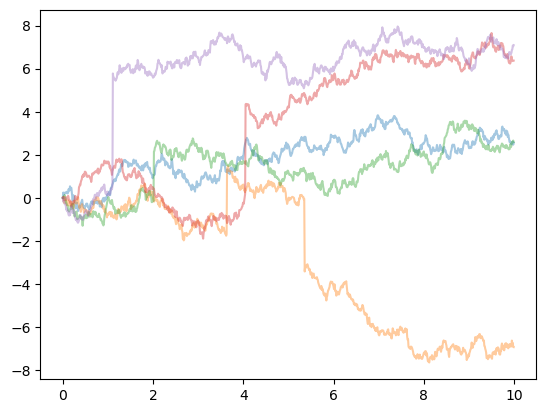

In [3]:
process = StochasticProcess(time=10, timestep=0.01, number=50, poisson_rate=10, shape=1, scale=1)
t, Xt = process.levyprocess()
process.plot_solution(t, Xt, with_mean=False, with_var=False, num_max=5)

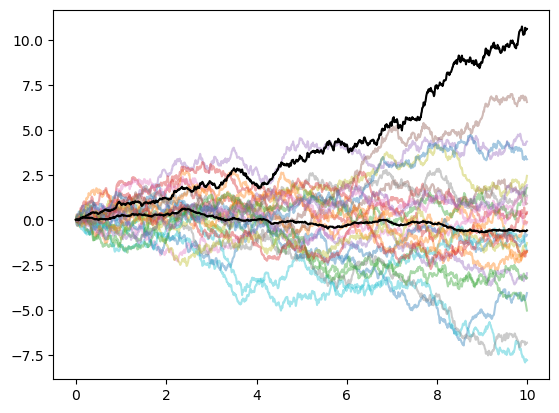

In [5]:
process = StochasticProcess(time=20, timestep=0.01, number=25, poisson_rate=6, shape=1, scale=1)
t, Xt = process.brownianmotion()
process.plot_solution(t, Xt, with_mean=True, with_var=True)    

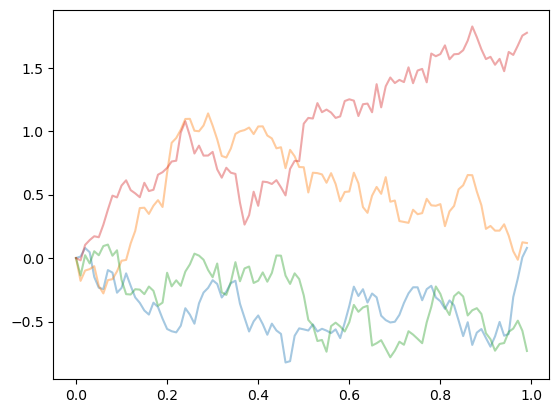

In [7]:
# from stochastic_processes import StochasticProcess
process = StochasticProcess(time=1, timestep=0.01, number=4, poisson_rate=6, shape=1, scale=1)
t, Xt = process.brownianmotion()
process.plot_solution(t, Xt)
# mean_stop, var_stop = process.stoppingstatistics(Xt, t, tau=1) # Mean is about half. Should be 1.
# print(mean_stop, var_stop)

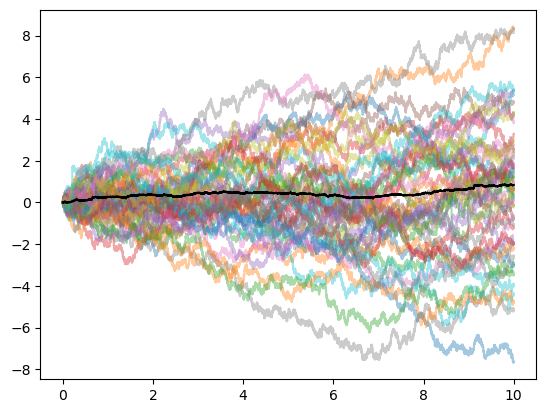

(1.1813399999999998, 1.0637374794)

In [74]:
# from stochastic_processes import StochasticProcess
process = StochasticProcess(time=10, timestep=0.0005, number=100, poisson_rate=25, shape=0.5, scale=1)
t, Xt = process.levyprocess()

process.plot_solution(t, Xt, with_mean=True, num_max=50)
process.stoppingstatistics(Xt, t, tau=1)

c:\Users\gouwenss\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

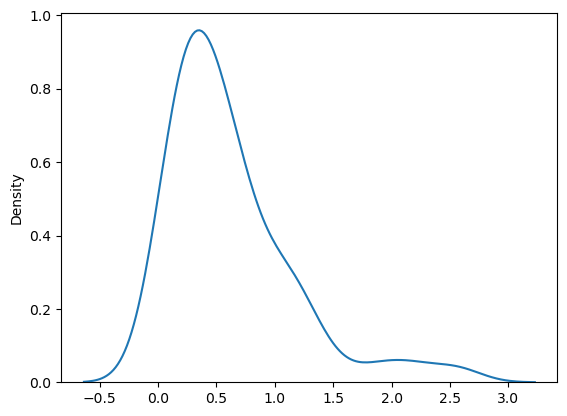

In [73]:
stopping_indices = process.findstoppingindices(Xt, tau=1)
stopping_times = t[stopping_indices]

sns.kdeplot(stopping_times)

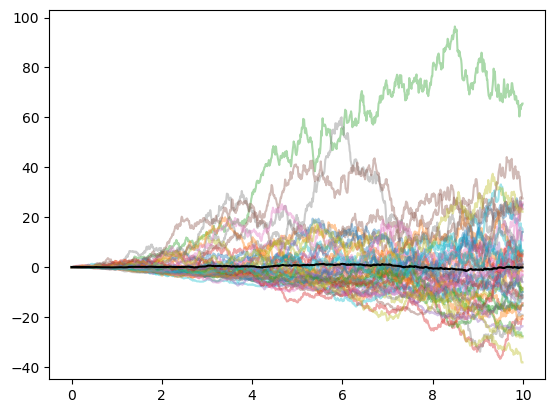

In [63]:
f_function = lambda t, x: t+x

integrate = StochasticIntegration(time=10, timestep=0.01, number=100, shape=1, scale=0.1, integrator="brownianmotion")
t, Xt = integrate.stochastic_integral(fun=f_function)
integrate.plot_solution(t, Xt, num_max=50, with_mean=True, with_var=False)

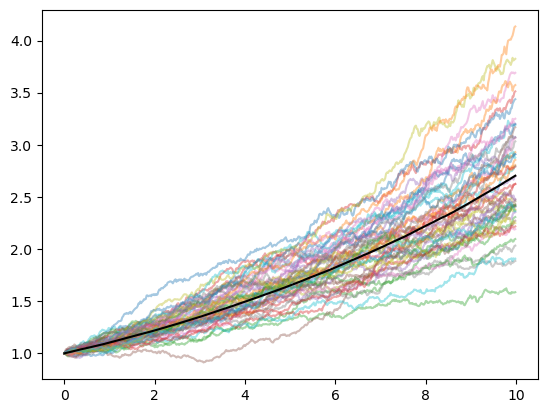

0.29950796192658663 0.09477065798395343


In [109]:
sdesolve = SdeSolver(time=10, timestep=0.02, number=1000, poisson_rate=10, shape=.2, scale=2, integrator="brownianmotion")

t, Xt = sdesolve.solve_sde(value_init=1)
sdesolve.plot_solution(t, Xt, with_mean=True, with_var=False)

returns = sdesolve.european_option(t, Xt, call_time=9, strike_price=2.2)

print(np.mean(returns), np.var(returns))

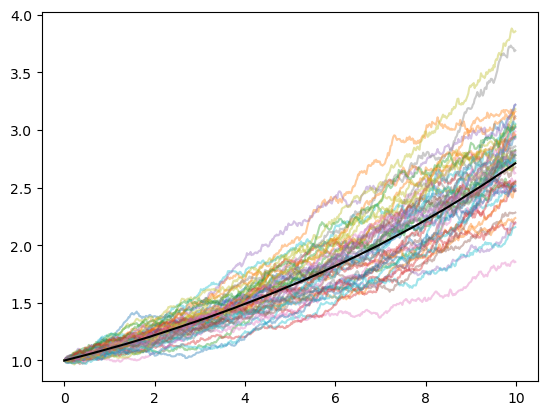

In [62]:
# Do thest this. add a function f and g such that the parameters give prettier results.
sdesolve = SdeSolver(time=10, timestep=0.02, number=2500, poisson_rate=4, shape=1, scale=1, integrator="brownianmotion")
t, Xt = sdesolve.solve_sde(value_init=1)

sdesolve.plot_solution(t, Xt, with_mean=True, with_var=False)

In [1]:
from dataclasses import dataclass

@dataclass
class 

In [ ]:
@dataclass
class StandardFunctions():
    pass